In [1]:
#barcode redundancy theoretical calculator (stolen fro Nat, though this is really just the birthday problem)
import random
def draw(barcodes, draws): 
    barcode_list = list(range(barcodes)) 
    duplicates = 0 
    barcodes_found = set() 
    for i in range(draws): 
        barcode = random.choice(barcode_list) 
        if barcode in barcodes_found: 
            duplicates += 1 
        barcodes_found.add(barcode) 
    return duplicates

print(draw(300000,100000))
# The mutants and then pick 100000 barcodes after this is how many barcodes will have 2 mutants)
print(draw(1000000,100000))
print(draw(10000000,100000))


14903
4816
464


In [2]:
#Here I parse sequence file and print out the number of reads in the file
from Bio import SeqIO
import pandas as pd

mockDataParsed = SeqIO.parse("NP_11_18_13_mockData.txt", "fastq")

readCounter = 0

for record in mockDataParsed:
    readCounter += 1

print(readCounter)

100


In [3]:
#this is the template for alignment and should be a fasta file with only one sequence in it
templateParsed = SeqIO.parse('rbcL_codonopt_barcoded.txt', 'fasta')
TEMPLATE_STRING = None
for record in templateParsed:
    assert TEMPLATE_STRING == None
    TEMPLATE_STRING = str(record.seq)
    RCtemplateString = record.seq.reverse_complement()
    TEMPLATE_TRANSLATION = str(record.seq.translate(to_stop=True))

SEARCH_MOTIF_LENGTH = 11

# This is the FULL sequence between the barcode and the last coding nucleotide (including stop codons)
BARCODE_FLANK = 'CCTGCAGGCTATTA'

print(TEMPLATE_TRANSLATION)

MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFAAESSTGTNVEVCTTDDFTRGVDALVYEVDEARELTKIAYPVALFDRNITDGKAMIASFLTLTMGNNQGMGDVEYAKMHDFYVPEAYRALFDGPSVNISALWKVLGRPEVDGGLVVGTIIKPKLGLRPKPFAEACHAFWLGGDFIKNDEPQGNQPFAPLRDTIALVADAMRRAQDETGEAKLFSANITADDPFEIIARGEYVLETFGENASHVALLVDGYVAGAAAITTARRRFPDNFLHYHRAGHGAVTSPQSKRGYTAFVHCKMARLQGASGIHTGTMGFGKMEGESSDRAIAYMLTQDEAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLGNANVILTAGGGAFGHIDGPVAGARSLRQAWQAWRDGVPVLDYAREHKELARAFESFPGDADQIYPGWRKALGVEDTRSALPA


/opt/anaconda3/envs/NP_11_dataAnalysis/lib/python3.7/site-packages/Bio/Seq.py:2742: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [54]:
# here I convert a SeqIO file into a pandas dataframe so that I can do statistics
# First I parse the fastq file, then I make a dictionary with the info I want then I make a dataframe
# I want to make a new column that identifies if there is a mutation and what it is
# Also I'll need to pair paired reads somehow (http://bytesizebio.net/2011/11/10/short-bioinformatics-hacks-reading-mate-pairs-from-a-fastq-file/)

import numpy as np
import matplotlib.pyplot as plt
import itertools
import math

def processRecord(rec, sequences, AVGphredQ, basesWphredQundertwenty, translations, barcodePresence,
                  barcodeList, nonBarcodeReadAlignment, mutation, numberOfMutations, readIDs = None):
    if readIDs is not None:
        readIDs.append(rec.id)
    sequences.append(str(rec.seq))
    AVGphredQ.append(np.mean(rec.letter_annotations['phred_quality']))
    badReads = 0
    for qualityScore in rec.letter_annotations['phred_quality']:
        if qualityScore < 20:
            badReads += 1
    basesWphredQundertwenty.append(badReads)
    barcodeStart = rec.seq.find(BARCODE_FLANK)
    mutant = 'no mutation'
    
    # This finds barcodes and translations
    # I'm leaving a bit of this translation on the table but this explicitly gets it in frame

    if barcodeStart != -1:
        # first get a translation of the region next to the barcode
        translations.append(str(rec.seq[barcodeStart + 14:barcodeStart + 62].reverse_complement().translate(to_stop=True)))
         
        # if there is a barcode add a column saying that there was one
        barcodeToAppend = str(rec.seq[barcodeStart - 15:barcodeStart])
        if barcodeToAppend == '' or barcodeToAppend == None or len(barcodeToAppend) != 15:
            barcodeList.append('no barcode found')
            barcodePresence.append(False)
        else:
            barcodeList.append(barcodeToAppend)
            barcodePresence.append(True)
        #this collects the barcode sequence
        nonBarcodeReadAlignment.append(-1) 
        # This just fills in an empty space for the alignment of the nonbarcode read
        mutationCounter = 0
        # The start of the enumeration should be the end of the protein sequence, in this case 
        # it is as long as the barcode flank
        stopCodonPosition = barcodeStart + len(BARCODE_FLANK)
        lenOfCodingSequence = len(rec.seq) - stopCodonPosition
        lengthInFrame = lenOfCodingSequence - (lenOfCodingSequence % 3)
        barcodeReadStart = len(TEMPLATE_TRANSLATION) - (lengthInFrame // 3)
        for position, aminoAcid in enumerate(str((rec.seq[stopCodonPosition:stopCodonPosition + lengthInFrame].reverse_complement().translate(to_stop = True)))):
            templateAminoAcid = TEMPLATE_TRANSLATION[barcodeReadStart + position]
            if aminoAcid != templateAminoAcid:
                mutant = str(templateAminoAcid) + str(barcodeReadStart + position) + str(aminoAcid)
                mutationCounter += 1
        mutation.append(mutant)
        numberOfMutations.append(mutationCounter)
        return
    
    nonBarcodeReadStart = TEMPLATE_STRING.find(str(rec.seq[:SEARCH_MOTIF_LENGTH])) 

    # this finds the read in the template seq
    if nonBarcodeReadStart != -1:
        barcodePresence.append(False) 
        # this indicates that no barcode was found
        barcodeList.append('valid nonbarcode read')
        # this finds the frame
        frame = nonBarcodeReadStart % 3  
        # I have to subtract the frame to figure out where to start translating
        nonBarcodeReadingFrame = rec.seq[3 - frame:] 
        translations.append(str(nonBarcodeReadingFrame.translate(to_stop = True))) 
        # This adds in where the alignment begins in the DNA
        nonBarcodeReadAlignment.append(nonBarcodeReadStart) 
        # This adds in where the alignment begins in the protein
        nonBarcodeTranslationStart = math.floor(nonBarcodeReadStart / 3) + 1 
        # Here I will compare the template translation to the read translation
        mutationCounter = 0
        for position, aminoAcid in enumerate(str(nonBarcodeReadingFrame.translate(to_stop = True))):
            templateIndex = nonBarcodeTranslationStart + position
            if templateIndex >= len(TEMPLATE_TRANSLATION):
                break
#             print('the index is ' + str(templateIndex))
            templateAminoAcid = TEMPLATE_TRANSLATION[templateIndex]
            if aminoAcid != templateAminoAcid:
                mutant = str(templateAminoAcid) + str(templateIndex) + str(aminoAcid)
                mutationCounter += 1
        mutation.append(mutant)
        numberOfMutations.append(mutationCounter)
        return
    
    # if no barcode or other homolgy is found this takes care of failures
    translations.append('no homology found')
    barcodePresence.append(False)
    barcodeList.append('no barcode found')
    nonBarcodeReadAlignment.append(-1)
    mutation.append(mutant)
    numberOfMutations.append(0)

# Here I can import any fastq file with reads
mockDataParsed = SeqIO.parse("NP-11-19-4-merged.fastq", "fastq")

readIDs = []
sequences1 = []
sequences2 = []
translations1 = []
translations2 = []
AVGphredQ1 = []
AVGphredQ2 = []
basesWphredQundertwenty1 = []
basesWphredQundertwenty2 = []
barcodePresence1 = []
barcodePresence2 = []
nonBarcodeReadAlignment1 = []
nonBarcodeReadAlignment2 = []
barcodeList1 = []
barcodeList2 = []
mutation1 = []
mutation2 = []
numberOfMutations1 = []
numberOfMutations2 = []

#I'm going to put paired reads into the same row in this dictionary
#The file will have to have an even number of reads for this

for rec1, rec2 in itertools.zip_longest(mockDataParsed, mockDataParsed): 
    processRecord(rec1, sequences1, AVGphredQ1, basesWphredQundertwenty1, translations1, 
                  barcodePresence1, barcodeList1, nonBarcodeReadAlignment1, mutation1, numberOfMutations1, readIDs)
    processRecord(rec2, sequences2, AVGphredQ2, basesWphredQundertwenty2, translations2, 
                  barcodePresence2, barcodeList2, nonBarcodeReadAlignment2, mutation2, numberOfMutations2)

untrimmed_data = {
    'Read ID': readIDs,
    'Sequence1': sequences1,
    'Sequence2': sequences2,
    'translation1': translations1,
    'translation2': translations2,
    'Average phredQ1': AVGphredQ1,
    'Average phredQ2': AVGphredQ2,
    'Number of bases with phredQ under 20 read 1': basesWphredQundertwenty1,
    'Number of bases with phredQ under 20 read 2': basesWphredQundertwenty2,
    'Is there a barcode in read 1?' : barcodePresence1,
    'Is there a barcode in read 2?' : barcodePresence2,
    'Nonbarcode read start position1' : nonBarcodeReadAlignment1,
    'Nonbarcode read start position2' : nonBarcodeReadAlignment2,
    'Barcode sequence1' : barcodeList1,
    'Barcode sequence2' : barcodeList2,
    'Mutation1' : mutation1,
    'Mutation2' : mutation2,
    'Number of mutations in read 1' : numberOfMutations1,
    'Number of mutations in read 2' : numberOfMutations2,
                 }

dfRaw = pd.DataFrame(untrimmed_data)

dfRaw.head(50)

/opt/anaconda3/envs/NP_11_dataAnalysis/lib/python3.7/site-packages/Bio/Seq.py:2742: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


,Read ID,Sequence1,Sequence2,translation1,translation2,Average phredQ1,Average phredQ2,Number of bases with phredQ under 20 read 1,Number of bases with phredQ under 20 read 2,Is there a barcode in read 1?,Is there a barcode in read 2?,Nonbarcode read start position1,Nonbarcode read start position2,Barcode sequence1,Barcode sequence2,Mutation1,Mutation2,Number of mutations in read 1,Number of mutations in read 2
0,FS10000719:32:BPC29518-1720:1:1101:1010:1000,TGAAGCACAAGGCCCCTCTTCTTAGCTCCATGATTAATTCCTAATT...,ATAGGGAGTGGTAAAATAACTCTATCAATGATAGAGTGTCAACAAA...,EAQGPSS,no homology found,36.509934,36.576159,1,2,False,False,1037,-1,valid nonbarcode read,no barcode found,Y352S,no mutation,2,0
1,FS10000719:32:BPC29518-1720:1:1101:1020:1000,TGAAGCACAAGGCCCCTTTTATCGCCAGTCGTGGGGAGGGATGAAG...,ATAGGGAGTGGTAAAATAACTCTATCAATGATAGAGTGTCAACAAA...,EAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLGNANVILTA...,WRKALGVEDTRSALPA,36.920530,36.827815,0,1,False,True,1037,-1,valid nonbarcode read,GGAGGCGATTAAGAC,no mutation,no mutation,0,0
2,FS10000719:32:BPC29518-1720:1:1101:1100:1000,ATAGGGAGTGGTAAAATAACTCTATCAATGATAGAGTGTCAACAAA...,TGAAGCACAAGGCCCCTTTTATCGCCAGTCGTGGGGAGGGATGAAG...,WRKALGVEDTRSALPA,EAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLGNANVILTA...,36.827815,36.841060,1,0,True,False,-1,1037,CCAGCCGCATCTACA,valid nonbarcode read,no mutation,no mutation,0,0
3,FS10000719:32:BPC29518-1720:1:1101:1110:1000,ATAGGGAGTGGTAAAATAACTCTATCAATGATAGAGTGTCAACAAA...,TGAAGCACAAGGCCCCTTTTATCGCCAGTCGTGGGGAGGGATGAAG...,WRKALGVEDTRSALPA,EAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLANANVILTA...,36.668874,36.430464,1,1,True,False,-1,1037,GAGCGAGTGAGTAAG,valid nonbarcode read,no mutation,G383A,0,1
4,FS10000719:32:BPC29518-1720:1:1101:1180:1000,TGAAGCACAAGGCCCCTTTTATCGCCAGTCGTGGGGAGGGATGAAG...,ATAGGGAGTGGTAAAATAACTCTATCAATGATAGAGTGTCAACAAA...,EAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLGNANVILTA...,WRKALGVEDTRSALPA,36.841060,36.827815,0,1,False,True,1037,-1,valid nonbarcode read,GCAGGGCAGAATGAG,no mutation,no mutation,0,0
5,FS10000719:32:BPC29518-1720:1:1101:1190:1000,TGAAGCACAAGGCCCCTTTTATCGCCAGTCGTGGGGAGGGATGAAG...,ATAGGGAGTGGTAAAATAACTCTATCAATGATAGAGTGTCAACAAA...,EAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLGNANVILTA...,WRKALGVEDTRSALPA,36.748344,34.721854,1,10,False,True,1037,-1,valid nonbarcode read,CCGTGCCGCAAAAAG,no mutation,Y447N,0,1
6,FS10000719:32:BPC29518-1720:1:1101:1250:1000,TGAAGCACAAGGCCCCTTTTATCGCCAGTCGTGGGGAGGGATGAAG...,ATAGGGAGTGGTAAAATAACTCTATCAATGATAGAGTGTCAACAAA...,EAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLGNANVILTA...,WRKAVGVEDSRSALPA,32.099338,31.463576,16,22,False,True,1037,-1,valid nonbarcode read,TCACTTTGGGAAGGC,no mutation,T459S,0,3
7,FS10000719:32:BPC29518-1720:1:1101:1270:1000,ATAGGGAGTGGTAAAATAACTCTATCAATGATAGAGTGTCAACAAA...,TGAAGCACAAGGCCCCTTTTATCGCCAGTCGTGGGGAGGGATGAAG...,WRKALGVEDTRSALPA,EAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLGNANVILTA...,36.748344,36.271523,1,1,True,False,-1,1037,GTTTACTTTGCAAAC,valid nonbarcode read,Y447N,no mutation,1,0
8,FS10000719:32:BPC29518-1720:1:1101:1320:1000,ATAGGGAGTGGTAAAATAACTCTATCAATGATAGAGTGTCAACAAA...,TGAAGCACAAGGCCCCTTTTATCGCCAGTCGTGGGGAGGGATGAAG...,WRKALGVEDTRSALPA,EAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLGNANVILTA...,36.827815,36.364238,1,0,True,False,-1,1037,AATGTGGGGACTACG,valid nonbarcode read,no mutation,no mutation,0,0
9,FS10000719:32:BPC29518-1720:1:1101:1360:1000,TGAAGCACAAGGCCCCTTTCTCTGCAACCATGATTAATTCCTAATT...,ATAGGGAGTGGTAAAATAACTCTATCAATGATAGAGTGTCAACAAA...,EAQGPFLCNHD,no homology found,36.403974,35.066225,3,2,False,False,1037,-1,valid nonbarcode read,no barcode found,W356D,no mutation,5,0


In [55]:
# Pull out rows (paired reads) that have one barcode in one of the reads and only 1 mutation between the reads

i = 0

mutantRows = []
WTRows = []
WTorSingleRow = []
qualityTrimmed = []

# Make a new column in the dataframe that has a barcode from the two barcode columns
dummyBarcode = 'Barcode was not added'
dfRaw['Barcode'] = dummyBarcode
dfRaw['Barcode'] = np.where(
    (dfRaw['Barcode sequence1'] == 'no barcode found') | (dfRaw['Barcode sequence1'] == 'valid nonbarcode read'), 
    dfRaw['Barcode sequence2'], 
    dfRaw['Barcode sequence1'])

# Trim away low quality reads
averageQualityCutoff = 25
maxBadReads = 5
for index, row in dfRaw.iterrows():
    if row['Average phredQ1'] > averageQualityCutoff and row['Average phredQ2'] > averageQualityCutoff and \
        row['Number of bases with phredQ under 20 read 1'] < maxBadReads and \
        row['Number of bases with phredQ under 20 read 2'] < maxBadReads:
        qualityTrimmed.append(index)
        i += 1      
dfQuality = dfRaw.filter(qualityTrimmed, axis = 'index')

# Extract a new dataframe that only has rows from the quality dataframe with exactly one mutation and a barcode
for index, row in dfQuality.iterrows():
    if row['Number of mutations in read 1'] + row['Number of mutations in read 2'] == 1 and \
        row['Is there a barcode in read 1?'] ^ row['Is there a barcode in read 2?']:
        mutantRows.append(index)
        i += 1
dfMutants = dfQuality.filter(mutantRows, axis = 'index')

# In the single-mutants dataframe make a new column that contains the unique mutation
dummyMutation = 'Mutation was not added'
dfMutants['Single mutation'] = dummyMutation
dfMutants['Single mutation'] = np.where(dfMutants['Mutation1'] == 'no mutation', 
                                        dfMutants['Mutation2'], 
                                        dfMutants['Mutation1']) 

# Make a dataframe that contains any row with a barcode and zero or 1 mutations
for index, row in dfQuality.iterrows():
    if row['Number of mutations in read 1'] + row['Number of mutations in read 2'] <= 1 and \
        row['Is there a barcode in read 1?'] ^ row['Is there a barcode in read 2?']:
        WTorSingleRow.append(index)
        i += 1      
dfWTorSingle = dfQuality.filter(WTorSingleRow, axis = 'index')



# How many of each mutant are there?

print('Single mutant counts: ')
dfMutants['Single mutation'].value_counts()

# How many of each barcode are there?
print('Single mutant barcode counts: ')
dfMutants['Barcode'].value_counts()

print('Total mutant barcode counts: ')
dfWTorSingle['Barcode'].value_counts()



        
dfMutants.head()



    
    

Single mutant counts: 
Single mutant barcode counts: 
Total mutant barcode counts: 


,Read ID,Sequence1,Sequence2,translation1,translation2,Average phredQ1,Average phredQ2,Number of bases with phredQ under 20 read 1,Number of bases with phredQ under 20 read 2,Is there a barcode in read 1?,...,Nonbarcode read start position1,Nonbarcode read start position2,Barcode sequence1,Barcode sequence2,Mutation1,Mutation2,Number of mutations in read 1,Number of mutations in read 2,Barcode,Single mutation
3,FS10000719:32:BPC29518-1720:1:1101:1110:1000,ATAGGGAGTGGTAAAATAACTCTATCAATGATAGAGTGTCAACAAA...,TGAAGCACAAGGCCCCTTTTATCGCCAGTCGTGGGGAGGGATGAAG...,WRKALGVEDTRSALPA,EAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLANANVILTA...,36.668874,36.430464,1,1,True,...,-1,1037,GAGCGAGTGAGTAAG,valid nonbarcode read,no mutation,G383A,0,1,GAGCGAGTGAGTAAG,G383A
7,FS10000719:32:BPC29518-1720:1:1101:1270:1000,ATAGGGAGTGGTAAAATAACTCTATCAATGATAGAGTGTCAACAAA...,TGAAGCACAAGGCCCCTTTTATCGCCAGTCGTGGGGAGGGATGAAG...,WRKALGVEDTRSALPA,EAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLGNANVILTA...,36.748344,36.271523,1,1,True,...,-1,1037,GTTTACTTTGCAAAC,valid nonbarcode read,Y447N,no mutation,1,0,GTTTACTTTGCAAAC,Y447N
10,FS10000719:32:BPC29518-1720:1:1101:1390:1000,TGAAGCACAAGGCCCCTTTTATCGCCAGTCGTGGGGAGGGATGAAG...,ATAGGGAGTGGTAAAATAACTCTATCAATGATAGAGTGTCAACAAA...,EAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLGNANVILTA...,WRKALGVEDTRSALPA,36.841060,36.589404,0,1,False,...,1037,-1,valid nonbarcode read,CGAATAGGAGAAATA,no mutation,Y447N,0,1,CGAATAGGAGAAATA,Y447N
13,FS10000719:32:BPC29518-1720:1:1101:1530:1000,ATAGGGAGTGGTAAAATAACTCTATCAATGATAGAGTGTCAACAAA...,TGAAGCACAAGGCCCCTTTTATCGCCAGTCGTGGGGAGGGATGAAG...,WRKALGVEDTRSALPA,EAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLGNANVILTA...,36.748344,36.430464,1,1,True,...,-1,1037,AGGTCTATCAATGAG,valid nonbarcode read,Y447N,no mutation,1,0,AGGTCTATCAATGAG,Y447N
14,FS10000719:32:BPC29518-1720:1:1101:1560:1000,TGAAGCACAAGGCCCCTTTTATCGCCAGTCGTGGGGAGGGATGAAG...,ATAGGGAGTGGTAAAATAACTCTATCAATGATAGAGTGTCAACAAA...,EAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLGNANVILTA...,WRKALGVEDTRSALPA,36.682119,36.417219,0,2,False,...,1037,-1,valid nonbarcode read,CAAGTAGGGAATGGT,no mutation,Y447N,0,1,CAAGTAGGGAATGGT,Y447N


In [56]:

# How many of each mutant are there?
print('Single mutant counts: ')
print(str(dfMutants['Single mutation'].value_counts()))

# How many of each barcode are there among single mutants?
print('Single mutant barcode counts: ')
print(dfMutants['Barcode'].value_counts())

# How many of each barcode are there among among zero and single mutants?
print('Total mutant barcode counts: ')
print(str(dfWTorSingle['Barcode'].value_counts()))

# How many barcodes are there for each mutation? Answer as a histogram
print(str(dfMutants.groupby('Single mutation')['Barcode'].nunique().head()))

# How many mutations are there for each barcode? Answer as a histogram
print(str(dfMutants.groupby('Barcode')['Single mutation'].nunique().head()))

Single mutant counts: 
Y447N    61441
E380Q      937
F351L      887
A385T      779
G394R      709
         ...  
N381P        1
R451E        1
N384F        1
G377Y        1
F379K        1
Name: Single mutation, Length: 1180, dtype: int64
Single mutant barcode counts: 
ACTAGACCAGGGAAT    274
CCAATGTGAGCAGCG    273
CGACAAGCAGCCCTT    253
CGCAGGTCCCACCGA    234
CATCCGAGCTCGCAG    229
                  ... 
TGCCGGGCTCCACAA      1
GCAAAGCATCATAAA      1
GCGAGAATATGTAGA      1
ATGCGGCCCTTCCCT      1
ATGCGAGCATGGGAA      1
Name: Barcode, Length: 23531, dtype: int64
Total mutant barcode counts: 
GGAGGGAACACTAGT    1087
CATCCGAGCTCGCAG    1028
TCTCGTGCACGTCCT     955
TCTACATCTGGGATG     868
ATACCAACTATTTAG     848
                   ... 
GAAGTGAACGCGACA       1
TCCTCGGGTGTGTGC       1
ACTGGCTGTGGCCAA       1
GCCTCTGAGCGCACT       1
CGCCCTCACTCGTTC       1
Name: Barcode, Length: 36434, dtype: int64
Single mutation
A361C      7
A361D    162
A361E     63
A361F     47
A361G     67
Name: Barcode, dt

(array([0.000e+00, 7.441e+03, 3.326e+03, 2.594e+03, 2.014e+03, 1.754e+03,
        1.319e+03, 1.068e+03, 7.930e+02, 6.260e+02, 5.020e+02, 3.970e+02,
        2.870e+02, 2.520e+02, 1.790e+02, 1.510e+02, 1.310e+02, 1.000e+02,
        1.020e+02, 7.900e+01, 5.500e+01, 4.800e+01, 3.900e+01, 3.100e+01,
        2.600e+01, 2.300e+01, 2.000e+01, 1.600e+01, 1.500e+01, 1.600e+01,
        1.700e+01, 9.000e+00, 1.300e+01, 1.000e+01, 8.000e+00, 2.000e+00,
        5.000e+00, 7.000e+00, 1.000e+00, 4.000e+00, 6.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 2.000e+00,
        1.000e+00, 4.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+0

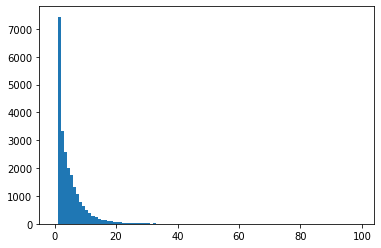

In [70]:

MutsperBarc = dfMutants.groupby('Barcode')['Single mutation'].nunique()
plt.hist(MutsperBarc, bins = range(0,100,1))
#print('This is a histogram of how many unique mutations each barcode has')

This is a histogram of how many unique barcodes each mutation has


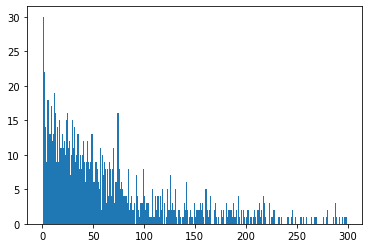

In [72]:

BarcsperMut = dfMutants.groupby('Single mutation')['Barcode'].nunique()
plt.hist(BarcsperMut, bins = range(0,300,1))



print('This is a histogram of how many unique barcodes each mutation has')

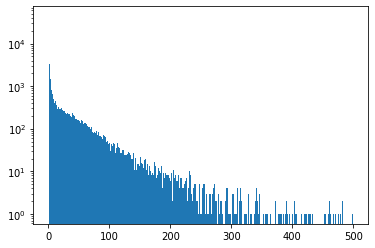

In [81]:


# plt.hist(dfMutants.groupby('Barcode')['Single mutation'].nunique(), density=True, bins=10)
plt.hist(dfRaw['Barcode'].value_counts(), bins = range(0,500,1))
plt.yscale('log')

# plt.hist(dfMutants.groupby('Single mutation')['Barcode'].nunique(), density=True, bins=10)
# plt.hist(dfMutants['Single mutation'].value_counts(), density=True, bins=10)



In [7]:
#this should allow for filtering reads by quality

records = []
for rec in SeqIO.parse():
    lines += 1
    if min(rec.letter_annotations) > 20:
        records.append(rec)
        all_reads = [rec for rec in SeqIO.parse()]


good_reads = (
    rec
    for rec in SeqIO.parse("SRR020192.fastq", "fastq")
    if min(rec.letter_annotations["phred_quality"]) >= 20
)
count = SeqIO.write(good_reads, "good_quality.fastq", "fastq")
print("Saved %i reads" % count)

TypeError: parse() missing 2 required positional arguments: 'handle' and 'format'

In [137]:
#This takes two files with paired reads and makes one file where the reads go one after the other
#stolen from (http://bytesizebio.net/2011/11/10/short-bioinformatics-hacks-reading-mate-pairs-from-a-fastq-file/)

from Bio import SeqIO
import itertools
import sys
import os
def merge_fastq(fastq_path1, fastq_path2, outpath):
    outfile = open(outpath,"w")
    fastq_iter1 = SeqIO.parse(open(fastq_path1),"fastq")
    fastq_iter2 = SeqIO.parse(open(fastq_path2),"fastq")
    for rec1, rec2 in itertools.zip_longest(fastq_iter1, fastq_iter2):
        SeqIO.write([rec1,rec2], outfile, "fastq")
    outfile.close()

    
#Put files to be merged here and the file you want to make
    
merge_fastq('NP-11-19-6_S3_L001_R1_001.fastq', 'NP-11-19-6_S3_L001_R2_001.fastq', 'NP-11-19-6-merged.fastq')
    



In [76]:
print(str(dfRaw.count()))
print(str(dfQuality.count()))
print(str(dfWTorSingle.count()))
print(str(dfMutants.count()))


Read ID                                        1282289
Sequence1                                      1282289
Sequence2                                      1282289
translation1                                   1282289
translation2                                   1282289
Average phredQ1                                1282289
Average phredQ2                                1282289
Number of bases with phredQ under 20 read 1    1282289
Number of bases with phredQ under 20 read 2    1282289
Is there a barcode in read 1?                  1282289
Is there a barcode in read 2?                  1282289
Nonbarcode read start position1                1282289
Nonbarcode read start position2                1282289
Barcode sequence1                              1282289
Barcode sequence2                              1282289
Mutation1                                      1282289
Mutation2                                      1282289
Number of mutations in read 1                  1282289
Number of 

In [143]:
#Here I take the parsed sequence files and find barcodes within them and generate a text file with barcodes

realDataParsed = SeqIO.parse("NP-11-19-6-merged.fastq", "fastq")
barcodeCounter = 0
barcode = None
with open('barcodes_test_NP_11_19_6.txt', 'w') as openFile:
    for record in realDataParsed:
        if 'CCTGCAGGTTATTA' in record.seq:
            barcodeCounter += 1
            barcodeStart = record.seq.find('CCTGCAGGTTATTA')
            barcode = record.seq[barcodeStart - 15:barcodeStart]        
            openFile.write(str(barcode + '\n'))

print(barcodeCounter)

659012


In [78]:
from collections import Counter


fh = open('barcodes_test_NP_11_19_5.txt')
barcodeList = fh.readlines()
print(len(barcodeList))

barcode_counts = Counter(barcodeList)

#Counter(openfile).keys() # equals to list(set(words))
print(len(Counter(barcodeList[:5000]).keys()))
print(len(Counter(barcodeList[:10000]).keys()))
print(len(Counter(barcodeList[:20000]).keys()))
print(len(Counter(barcodeList[:40000]).keys()))
print(len(Counter(barcodeList[:80000]).keys()))
print(len(Counter(barcodeList[:160000]).keys()))
print(len(Counter(barcodeList[:320000]).keys()))
print(len(Counter(barcodeList[:640000]).keys()))
print(len(Counter(barcodeList[:1000000]).keys()))
print(len(Counter(barcodeList).keys()))



1230141
4616
8726
15799
26637
40794
56460
71946
89990
105835
114727


In [ ]:
#this bit should let us find every codon at a given position
fh = open('NP_11_18_13.txt')
openfile = fh.read()

codonOILeftFlank = 'CTTGACTAC'

numberofcodons = openfile.count(codonOILeftFlank)
#barcodeLocation = openfile.find(barcodeRightFlank, 100000)
print('There are ' + str(numberofcodons) + ' codons and they are:')
#print(barcodeLocation)
#print(openfile[barcodeLocation-20:barcodeLocation+10])
newstart = 0
for position in range(int(len(openfile))):
    position = openfile.find(codonOILeftFlank, newstart)
    #print(position)
#    if '\n' in openfile[position:position+4]:
#        newstart = position + 1
#        position = position + 1
    if openfile[position+1:position+4] != 'GCC':
        print(openfile[position+1:position+4])
        newstart = position + 1
        position = position + 1
#    else:
#        print(openfile[position+1:position+4])
#        newstart = position + 1
#        position = position + 1

In [47]:
#first I need to make a list of barcodes that appear more than once

fh = open('NP_11_18_13_barcodes.txt')
barcodeLines = fh.readlines()
f= open("NP_11_16_3_duplicateBarcodes.txt","w+")
#f.write('the duplicate barcodes are')
for line,i in enumerate(barcodeLines):
    if i in barcodeLines[0:line]:
        f.write(i)
    if i in barcodeLines[line + 1:]:
        f.write(i)
print('done')


KeyboardInterrupt: 

In [50]:
#I want to make a new file that only contains reads with barcodes that appear
#more than once along with their paired read

barcodeLeftFlank = 'TTAGGAATTAATCATGG'
barcode = None

fh = open('NP_11_16_3.txt')
fastqLines = fh.readlines()
fh.close()

fh = open('NP_11_16_3_duplicateBarcodes.txt')
dupicateBarcodes = fh.read()
fh.close()

fh = open('NP_11_16_3_fastqDuplicatesOnlytest.txt', 'w+')

for lineNumber,line in enumerate(fastqLines[:50000]):
    if barcodeLeftFlank in line:
        position = line.find(barcodeLeftFlank)
        barcode = line[position + 17:position + 32]
        if barcode != 'ATCCTGCAGGCTATT':
            if barcode in dupicateBarcodes:
                readNumberPosition = fastqLines[lineNumber-1].find(':N:') - 1
                fh.writelines('\nBarcode ' + barcode + ' has the following paired reads\n')
                if fastqLines[lineNumber-1][readNumberPosition] == '2':
                    fh.writelines(fastqLines[lineNumber-5:lineNumber-1])
                fh.writelines(fastqLines[lineNumber-1:lineNumber+3])
                if fastqLines[lineNumber-1][readNumberPosition] == '1':
                    fh.writelines(fastqLines[lineNumber+3:lineNumber+7])

                instance = 0
                for lineNumber2,line2 in enumerate(fastqLines):
                    if barcode in line2:
                        if lineNumber != lineNumber2:
                            readNumberPosition2 = fastqLines[lineNumber2-1].find(':N:') - 1
                            position2 = line2.find(barcodeLeftFlank)
                            barcodeRepeat = line2[position2 + 17:position2 + 32]
                            fh.writelines('\nThe next instance of barcode ' + barcodeRepeat + ' has the following paired reads \n')
                            if fastqLines[lineNumber2-1][readNumberPosition2] == '2':
                                fh.writelines(fastqLines[lineNumber2-5:lineNumber2-1])
                            fh.writelines(fastqLines[lineNumber2-1:lineNumber2+3])
                            if fastqLines[lineNumber2-1][readNumberPosition2] == '1':
                                fh.writelines(fastqLines[lineNumber2+3:lineNumber2+7])
                        instance = instance + 1
                fh.writelines('\nThere were ' + str(instance) + ' instances of this barcode \n')

print('done') 
fh.close()


    



done
